# EDA

Group Name: Data Evolve  
Name: Dmitry Sharukhin  
Email: sharuhinda@gmail.com  
Country: Russia  
College/Company: Finval GC  
Specialization: Data Science  

In [1]:
import numpy as np
print('Numpy version:', np.__version__)

import pandas as pd
print('Pandas version:', pd.__version__)

import matplotlib as mpl
print('Matplotlib version:', mpl.__version__)
import matplotlib.pyplot as plt

import seaborn as sns
print('Seaborn version:', sns.__version__)

from pandas_profiling import ProfileReport

import scipy
print('Scipy version:', scipy.__version__)

import statsmodels as sm
print('Statsmodels version:', sm.__version__)

import phik
from phik.report import plot_correlation_matrix

from sklearn.impute import SimpleImputer, KNNImputer

Numpy version: 1.23.5
Pandas version: 1.5.2
Matplotlib version: 3.6.2
Seaborn version: 0.12.1
Scipy version: 1.9.3
Statsmodels version: 0.13.5


In [2]:
# SETTINGS
#pd.set_option('display.max_columns', None)
sns.set_palette('Blues_r')

In [3]:
%matplotlib inline

In [4]:
df = pd.read_csv('datasets/bank-train.csv')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,50,blue-collar,single,basic.4y,no,no,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
1,51,services,married,professional.course,unknown,no,no,telephone,may,mon,...,5,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
2,46,technician,divorced,professional.course,no,yes,no,cellular,may,mon,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no
3,46,admin.,single,university.degree,no,yes,no,telephone,jun,mon,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no
4,25,services,single,high.school,no,no,no,cellular,may,thu,...,5,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28831 entries, 0 to 28830
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             28831 non-null  int64  
 1   job             28831 non-null  object 
 2   marital         28831 non-null  object 
 3   education       28831 non-null  object 
 4   default         28831 non-null  object 
 5   housing         28831 non-null  object 
 6   loan            28831 non-null  object 
 7   contact         28831 non-null  object 
 8   month           28831 non-null  object 
 9   day_of_week     28831 non-null  object 
 10  duration        28831 non-null  int64  
 11  campaign        28831 non-null  int64  
 12  pdays           28831 non-null  int64  
 13  previous        28831 non-null  int64  
 14  poutcome        28831 non-null  object 
 15  emp.var.rate    28831 non-null  float64
 16  cons.price.idx  28831 non-null  float64
 17  cons.conf.idx   28831 non-null 

In [6]:
skip_profiling = True
profile = None
if not skip_profiling:
    profile = ProfileReport(df, title='Preliminary EDA')
    profile

Some insights and things to explore and clarify based on report above:  
1. 7 duplicate rows - find them out and try to determine if it's error or coincidence due to depersonalization
2. (1) in bank sphere the presence of credit in default status usually is considered as a stop-factor for banking service, (2) there are no rows with y == 'yes' AND default == 'yes', (3) among 'unknown' observations there are some with y == 'yes', but it doesn't contain any useful info for model, (4) imputing will most probably use most frequent value ('no'), so in this way `default` isn't useful for model too => feature can be dropped safely
3. check correlations between features  
4. `loan` and `housing` features have 707 possibly shared records with 'unknown' value
5. `contact` feature can be one-hot encoded with 1 column (check if this feature contains useful info for model)
6. **Assumption**: `month` contains only 10 values (Jan and Feb are absent) with modal value 'May'. According to data description observations refer to period from May 2008 to November 2010 and ARE ORDERED BY DATE => we can try to restore month-year values based on the months order (CHECK FULL DATASET (1) for Jan and Feb values, (2) if restore data then in both datasets) + we can use months after 2008 year's financial crisis as a new feature  
**Conclusion**: (1) the whole dataset doesn't have 'jan' and 'feb' values, (2) `months_since_2018` will not be useful for prediction as all new instances are guaranteed to be further in time (extrapolation task). In case of interpolation task this feature could be useful
7. `day_of_week` feature have almost equal distribution and can be dropped  (if useless will be proved)
8. `campaign` feature should be cutted based on 1.5*IQR (calculate threshold value)
9. Explore `pdays`, `previous`, `poutcome` features:
    - `pdays` contains hidden NAN value (999) in 96% of records => can be dropped (+ explore correlation with `previous` and `poutcome` features)
    - `previous` feature contains zeros in 86% of records => check if can be dropped (+ explore correlation with `pdays` and `poutcome` features)
    - `potcome` feature contains 'nonexistent' value in 86% of records (probably the same where `previous` == 0) 
10. Impute real missing values left
11. (!!!) dataset is HIGHLY IMBALANCED => we have to be careful when dropping rows. Have to OVERSAMPLE positive rows before training model


In [7]:
# checking real number of missing values left
cat_nan_equiv = 'unknown'
num_nan_equiv = 999
print(f'Calculating real NaNs ratio using `{cat_nan_equiv}` and `{num_nan_equiv}` keyvalues:')
print('Column (value) \tNvalues \tRatio')
print('-'*40)
for col in df.columns:
    if df[col].dtype == 'object':
        nan_equiv = cat_nan_equiv
    else:
        nan_equiv = num_nan_equiv
    if nan_equiv in list(df[col]):
        freq_table = df[col].value_counts()
        print('{} (`{}`) \t{} \t{:.1f}%'.format(col, nan_equiv, freq_table[nan_equiv], 100 * freq_table[nan_equiv] / len(df)))

Calculating real NaNs ratio using `unknown` and `999` keyvalues:
Column (value) 	Nvalues 	Ratio
----------------------------------------
job (`unknown`) 	240 	0.8%
marital (`unknown`) 	58 	0.2%
education (`unknown`) 	1234 	4.3%
default (`unknown`) 	6051 	21.0%
housing (`unknown`) 	707 	2.5%
loan (`unknown`) 	707 	2.5%
duration (`999`) 	1 	0.0%
pdays (`999`) 	27734 	96.2%


In [8]:
# replacing string values with integers to ease further analysis
target_positive = 1
target_negative = 0
df.loc[:, 'y'] = df['y'].map({'yes': target_positive, 'no': target_negative})
df.head()

C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_14772\481506882.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'y'] = df['y'].map({'yes': target_positive, 'no': target_negative})


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,50,blue-collar,single,basic.4y,no,no,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0
1,51,services,married,professional.course,unknown,no,no,telephone,may,mon,...,5,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,0
2,46,technician,divorced,professional.course,no,yes,no,cellular,may,mon,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,0
3,46,admin.,single,university.degree,no,yes,no,telephone,jun,mon,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,0
4,25,services,single,high.school,no,no,no,cellular,may,thu,...,5,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,1


Implementation of function calculating Weight-of-Evidence (WoE, can be used as a replacer value when encoding categorical columns) and Information Value (can be used as feature's predictive power measure) for categorical columns  
Encode possible values using Weight-of-Evidence (WoE) and/or Information Value (IV) approach  
$ WoE = \ln(\frac{EventShare}{NonEventShare}) $  
$ IV = \sum{(EventShare-NonEventShare)*WoE} $

In [9]:
# (OLD, NOT USED) slower version using pandas dataframe
def get_woe_cat_df(X, y, return_details=False):
    num_events_total = y.sum()
    num_nonevents_total = len(y) - num_events_total
    grouper = pd.DataFrame({'feature': X, 'target': y}).groupby('feature')
    woe = pd.DataFrame({'num_events': grouper['target'].sum(), 'num_nonevents': grouper['target'].count() - grouper['target'].sum(), 'num_total': grouper['target'].count()})
    woe['events_share'] = woe['num_events'] / num_events_total
    woe['nonevents_share'] = woe['num_nonevents'] / num_nonevents_total
    woe['woe'] = np.log(woe['events_share'] / woe['nonevents_share'])
    woe['iv'] = (woe['events_share'] - woe['nonevents_share']) * woe['woe']
    if return_details:
        return (woe, woe['iv'].sum())
    else:
        return (woe['woe'], woe['iv'].sum())


In [10]:
# faster (almost 40% faster) version based on numpy arrays
def get_woe_cat(X, y, return_details=False):
    # a = a[a[:, 0].argsort()] # sort by 1st column
    # np.split(a[:,1], np.unique(a[:, 0], return_index=True)[1][1:]) # return grouped values
    num_events_total = y.sum()
    num_nonevents_total = len(y) - num_events_total
    grouper = pd.DataFrame({'feature': X, 'target': y}).groupby('feature', as_index=True)

    num_total = grouper['target'].count().to_numpy()
    num_events = grouper['target'].sum().to_numpy()
    index = grouper['target'].sum().index
    
    num_nonevents = num_total - num_events
    events_share = num_events / num_events_total
    nonevents_share = num_nonevents / num_nonevents_total
    woe = np.log((events_share+0.001) / (nonevents_share+0.001)) # adding small value to nominator and denominator to exclude division by 0 error
    iv = (events_share - nonevents_share) * woe
    
    if return_details:
        return (
            pd.DataFrame({
                    'num_events': num_events, 
                    'num_nonevents': num_nonevents,
                    'num_cat_total': num_total, 
                    'events_share': events_share, 
                    'nonevents_share': nonevents_share, 
                    'woe': woe, 
                    'iv': iv
                }, 
                index = index
            ),
            iv.sum()
        )
    else:
        return (pd.Series(woe, index=index, name='woe'), iv.sum())


In [11]:
print('Calculating prediction strength of features:')
print('Feature \tInformation Value')
print('-'*25)
for col in df.select_dtypes(include='object').columns.difference(other=['y']):
    (woe, iv) = get_woe_cat(df[col], df['y'])
    print('{:12} \t{:.4f}'.format(col, iv))

Calculating prediction strength of features:
Feature 	Information Value
-------------------------
contact      	0.2425
day_of_week  	0.0034
default      	0.1220
education    	0.0509
housing      	0.0006
job          	0.1740
loan         	0.0000
marital      	0.0307
month        	0.4527
poutcome     	0.5355


According to [web info](https://www.analyticsvidhya.com/blog/2021/06/understand-weight-of-evidence-and-information-value/) there are following ranges to determine predictive power of feature:  
  
| Information Value | Predictive power  |
| --- | --- |    
| <0.02             | Useless           |  
| 0.02 to 0.1       | Weak predictors   |  
| 0.1 to 0.3        | Medium Predictors |  
| 0.3 to 0.5        | Strong predictors |  
| >0.5              | Suspicious        |  

In [12]:
def interpret_iv(iv):
    if iv < 0.02:
        return 'useless'
    elif iv >= 0.02 and iv < 0.1:
        return 'weak'
    elif iv >=0.1 and iv < 0.3:
        return 'medium'
    elif iv >= 0.3 and iv < 0.5:
        return 'strong'
    else:
        return 'suspicious'

### 1. Duplicate rows

In [13]:
# search and display by mask
m = df.duplicated(keep=False)
df.loc[m, :]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
595,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,0
1309,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,0
3095,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,0
4657,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
8702,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
10205,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,0
13216,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0
15353,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,0
18168,71,retired,single,university.degree,no,no,no,telephone,oct,tue,...,1,999,0,nonexistent,-3.4,92.431,-26.9,0.742,5017.5,0
21658,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,0


[ASSUMPTION] We've lost the initial order of records when splitted dataset on training and testing parts. And now we can't verify that duplicated records are related to different years => different people. So we assume that duplicated records mean different observations and are not errors in dataset

### 2. `default` feature

Reminder: (1) in bank sphere the presence of credit in default status usually is considered as a stop-factor for banking service, (2) there are no rows with y == 'yes' AND default == 'yes', (3) among 'unknown' observations there are some with y == 'yes', but it doesn't contain any useful info for model, (4) imputing will most probably use most frequent value ('no'), so in this way `default` isn't useful for model too => feature can be dropped safely

But Information Value indicator shows that `default` has medium predictive power. So it's better to leave it for now and test model accuracy later with and without this feature

In [14]:
woe, iv = get_woe_cat(df['default'], df['y'])
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))
woe

Information Value: 0.1220 (medium)


feature
no         0.150267
unknown   -0.819063
yes       -0.110884
Name: woe, dtype: float64

In [15]:
#df = df.drop(columns='default')
#df.info()

In [16]:
# encoding by WoE values
df['default'] = df['default'].map(dict(zip(woe.index, woe.values)))
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
4700,36,admin.,married,university.degree,0.150267,yes,yes,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0
16575,44,admin.,married,high.school,0.150267,no,yes,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,0
8872,34,admin.,married,university.degree,0.150267,yes,no,cellular,may,mon,...,1,999,1,failure,-1.8,92.893,-46.2,1.264,5099.1,0
6416,35,blue-collar,married,basic.4y,-0.819063,yes,no,telephone,jun,tue,...,2,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,0
22854,68,retired,married,university.degree,0.150267,yes,no,cellular,jul,mon,...,2,999,1,failure,-1.7,94.215,-40.3,0.889,4991.6,1


[PIPELINE] This step should appear in preprocessing pipeline

### 3. Check correlations between features

In [17]:
personal_columns = list(df.columns[:4])+list(df.columns[5:7]) # exclude 'default' feature
print(personal_columns)

['age', 'job', 'marital', 'education', 'housing', 'loan']


In [18]:
print('Calculating prediction strength of features:')
print('Feature \tInformation Value')
print('-'*25)
for col in personal_columns:
    (woe, iv) = get_woe_cat(df[col], df['y'])
    print('{:12} \t{:.4f} ({})'.format(col, iv, interpret_iv(iv)))

Calculating prediction strength of features:
Feature 	Information Value
-------------------------
age          	0.1827 (medium)
job          	0.1740 (medium)
marital      	0.0307 (weak)
education    	0.0509 (weak)
housing      	0.0006 (useless)
loan         	0.0000 (useless)


Correlation also can help to suppose values to use in imputing process

We have numeric features only in 'Previous Campaign Results' (features 9-12) and 'Socioeconomic Indicators' (features 14-18) sections (not saying about age).  
Obviously 'Socioeconomic Indicators' don't have a causal relations with individual characteristics even if correlation is high. So we will not analyse these cross-section values.  
But we would like to test some relations between 'Individual Characteristics' section's features:
- is there any relation between:
    - age and job?
    - age and marital?
    - job and edication?
- are any of individual characteristics in relation with presence / absence of loans? 

In [19]:
# Step 1 - Replace all 'unknown' values with np.nan to ease further analysis
#df.replace({'unknown': np.nan}, inplace=True) ??? EXCLUDE

In [20]:
# Step 2 - use phi_k coefficient to measure degree of association
phik_overview = df[list(personal_columns)+['y']].phik_matrix(interval_cols=['age'])
phik_overview

,age,job,marital,education,housing,loan,y
age,1.000000,0.516505,0.418494,0.240274,0.000000,0.000000,0.222166
job,0.516505,1.000000,0.381468,0.673271,0.028369,0.022630,0.188271
marital,0.418494,0.381468,1.000000,0.257179,0.013131,0.000000,0.085282
education,0.240274,0.673271,0.257179,1.000000,0.025280,0.000000,0.091598
housing,0.000000,0.028369,0.013131,0.025280,1.000000,0.943155,0.000000
loan,0.000000,0.022630,0.000000,0.000000,0.943155,1.000000,0.000000
y,0.222166,0.188271,0.085282,0.091598,0.000000,0.000000,1.000000


<AxesSubplot: >

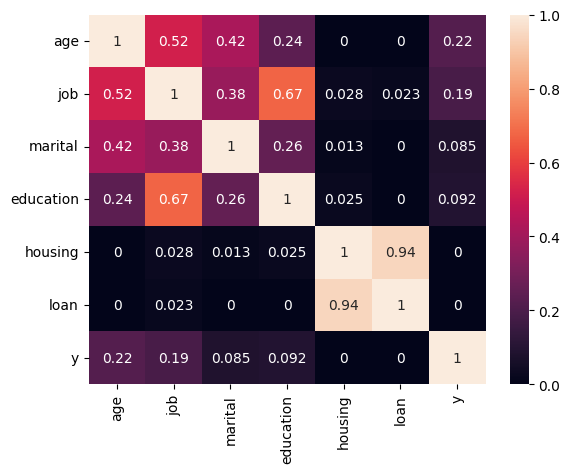

In [21]:
sns.heatmap(phik_overview, annot=True)

There are no features that highly correllated with target ('y')  
We have 3 relatively strong associations: (1) between education and job (0.67), (2) between job and age (0.52) and (3) marital and age (0.42)  
We can experiment with excluding one of these features from dataset when training model  

Let's show the association between education and job

In [22]:
# converting `education` column to ordered categorical type to get ordered chart output
education_ordered = ['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
df['education_ordered'] = pd.Categorical(df['education'], education_ordered, ordered=True)
df['education_ordered']

0                   basic.4y
1        professional.course
2        professional.course
3          university.degree
4                high.school
                ...         
28826    professional.course
28827      university.degree
28828      university.degree
28829               basic.4y
28830            high.school
Name: education_ordered, Length: 28831, dtype: category
Categories (8, object): ['unknown' < 'illiterate' < 'basic.4y' < 'basic.6y' < 'basic.9y' < 'high.school' < 'professional.course' < 'university.degree']

C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_14772\3322450664.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[t.get_text() for t in ax.get_xticklabels()], ha='right', rotation=35);


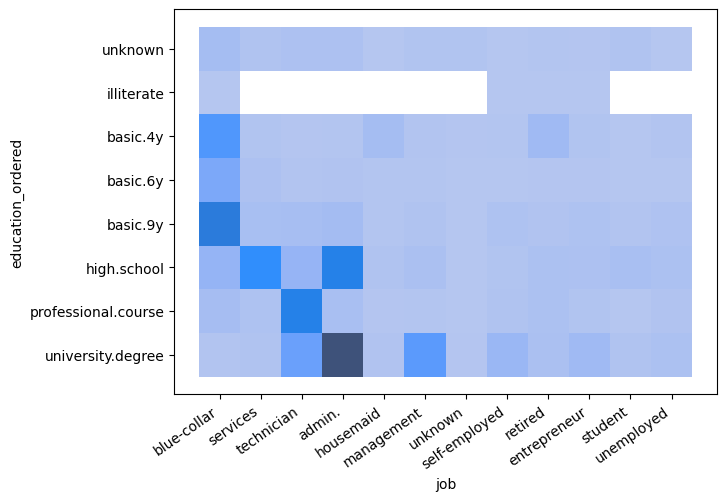

In [23]:
# building 2-axis histogram (like heatmap)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(data=df, x='job', y='education_ordered', ax=ax)
ax.set_xticklabels(labels=[t.get_text() for t in ax.get_xticklabels()], ha='right', rotation=35);

Let's check age distribution for other categorical features values to get some insights

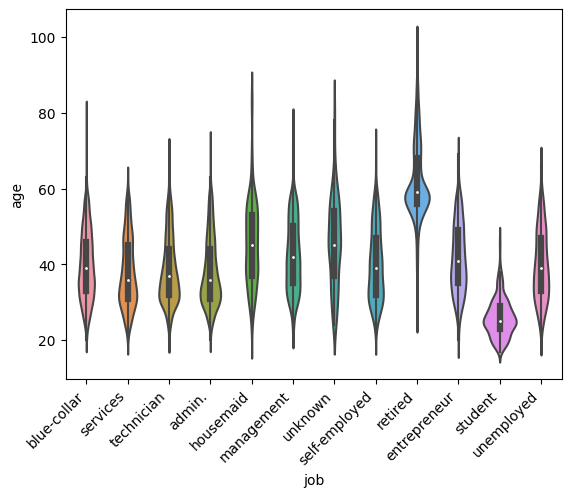

In [24]:
#fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.violinplot(data=df, x='job', y='age')
plt.xticks(rotation=45, ha='right');

As expected 'retired' and 'student' classes distributions are shifted. But for others there is nothing unusual

([<matplotlib.axis.YTick at 0x2255a85bf10>,
 [Text(0, 0, '0'),
  Text(0, 5, '5'),
  Text(0, 10, '10'),
  Text(0, 15, '15'),
  Text(0, 20, '20'),
  Text(0, 25, '25'),
  Text(0, 30, '30'),
  Text(0, 35, '35'),
  Text(0, 40, '40'),
  Text(0, 45, '45'),
  Text(0, 50, '50'),
  Text(0, 55, '55'),
  Text(0, 60, '60'),
  Text(0, 65, '65'),
  Text(0, 70, '70'),
  Text(0, 75, '75'),
  Text(0, 80, '80'),
  Text(0, 85, '85'),
  Text(0, 90, '90'),
  Text(0, 95, '95'),
  Text(0, 100, '100')])

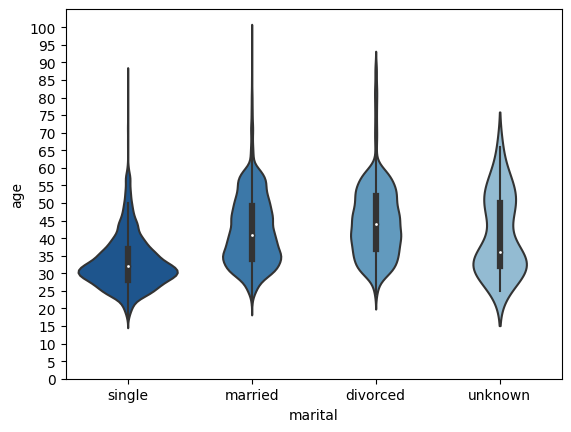

In [50]:
sns.violinplot(data=df, x='marital', y='age')
plt.yticks(range(0, 105, 5));

'unknown' value's distribution is multimodal. 1st mode is near equivalent of 'single' value's distribution one

C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_14772\3352124867.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.displot(data=df[df['marital'] != cat_nan_equiv], x='age', hue='marital', kind='kde', palette=sns.color_palette('pastel'), fill=True);


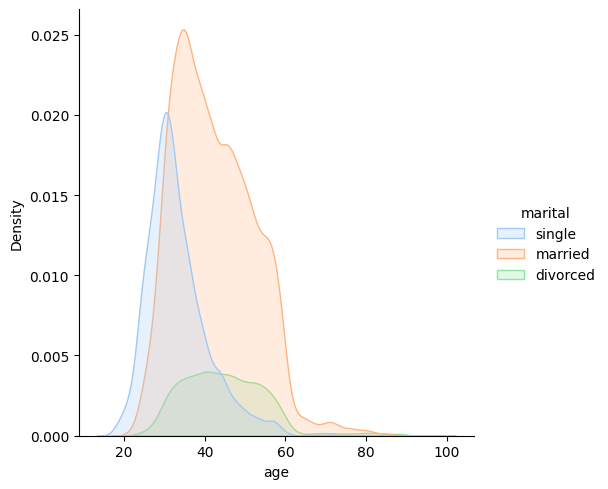

In [59]:
sns.displot(data=df[df['marital'] != cat_nan_equiv], x='age', hue='marital', kind='kde', palette=sns.color_palette('pastel'), fill=True);

For analyzed pairs we can impute values based on corresponding features:  
[PIPELINE]  
(!!!) Age should be binned  
Option 1:  
1. Use KNN-imputing / Simple imputing  
  
Option 2:  
1. Impute job and education (strongest association) based on most frequent corresponding values
2. Impute job based on most frequent value for corresponding age bin
3. Impute marital status based on most frequent value for corresponding age bin
4. Impute NANs left using any strategy or model (KNNImputer?)

In [38]:
"""
Calculates most_frequent values of base_feat for each corresponding value of reference_feat
Both features have to be categorical. If reference_feat is numerical it is possible to split it to bins
and use function using bins instead of exact values 
Returns a dictionary with reference_value: base_value pairs made using most_frequent strategy
"""
def get_reference_values(df, base_feat, reference_feat, nan_equiv=np.nan):
    is_numeric = True
    try:
        np.float64(nan_equiv)
    except ValueError:
        is_numeric = False
    if is_numeric and np.isnan(nan_equiv):
        ct = pd.crosstab(df[base_feat], df[reference_feat]) # rows = values of base feature, cols = values of reference feature
    else:
        ct = pd.crosstab(df.loc[(df[base_feat] != nan_equiv), base_feat], df[reference_feat])
    index = ct.index
    columns = ct.columns
    return {columns[i]: index[val] for i, val in enumerate(ct.to_numpy().argmax(axis=0))}

Test for imputing education based on most frequent job

In [41]:
m = df['education'] == cat_nan_equiv
df.loc[m, ['education', 'job']]

,education,job
9,unknown,housemaid
19,unknown,blue-collar
28,unknown,housemaid
97,unknown,services
105,unknown,blue-collar
...,...,...
28684,unknown,admin.
28768,unknown,student
28794,unknown,technician
28797,unknown,blue-collar


In [42]:
df.loc[m, 'education'] = df.loc[m, 'job'].map(get_reference_values(df, 'education', 'job', nan_equiv='unknown'))

In [43]:
df.loc[m, ['education', 'job']]

,education,job
9,basic.4y,housemaid
19,basic.9y,blue-collar
28,basic.4y,housemaid
97,high.school,services
105,basic.9y,blue-collar
...,...,...
28684,university.degree,admin.
28768,high.school,student
28794,professional.course,technician
28797,basic.9y,blue-collar


Test for imputing job based on most frequent education

In [44]:
m = df['job'] == cat_nan_equiv
df.loc[m, ['job', 'education']]

,job,education
20,unknown,high.school
142,unknown,university.degree
274,unknown,basic.4y
325,unknown,basic.4y
367,unknown,high.school
...,...,...
28177,unknown,basic.4y
28381,unknown,basic.4y
28483,unknown,basic.4y
28540,unknown,high.school


In [45]:
df.loc[m, 'job'] = df.loc[m, 'education'].map(get_reference_values(df, base_feat='job', reference_feat='education', nan_equiv='unknown'))
df.loc[m, ['job', 'education']]

,job,education
20,admin.,high.school
142,admin.,university.degree
274,blue-collar,basic.4y
325,blue-collar,basic.4y
367,admin.,high.school
...,...,...
28177,blue-collar,basic.4y
28381,blue-collar,basic.4y
28483,blue-collar,basic.4y
28540,admin.,high.school


To impute marital status based on age it's necessary to split age feature to bins

<AxesSubplot: xlabel='age', ylabel='Count'>

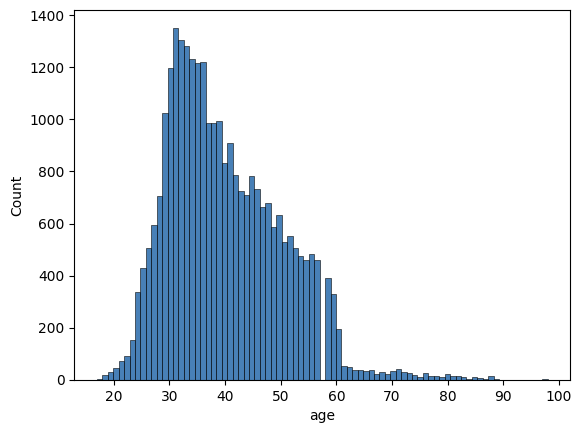

In [60]:
sns.histplot(data=df, x='age')

In [68]:
# splitting age to bins
# equal bins defined by total number
#bins = 10
bins = pd.IntervalIndex.from_breaks(np.arange(15, 100, 10))
df['age_bins'] = pd.cut(df['age'], bins=bins)

In [69]:
age_grouper = df.groupby('age_bins')

In [70]:
age_grouper['age'].count() * 100 / len(df)

age_bins
(15, 25]     4.078943
(25, 35]    36.124311
(35, 45]    30.973605
(45, 55]    20.176199
(55, 65]     7.165898
(65, 75]     0.919150
(75, 85]     0.482120
(85, 95]     0.076307
Name: age, dtype: float64

In [71]:
get_woe_cat(df['age_bins'], df['y'])

(feature
 (15, 25]    0.684230
 (25, 35]    0.054106
 (35, 45]   -0.333015
 (45, 55]   -0.249489
 (55, 65]    0.329375
 (65, 75]    1.625921
 (75, 85]    1.880634
 (85, 95]    1.397565
 Name: woe, dtype: float64,
 0.16638931807570645)

In [26]:
# imputation for marital
m = df['marital'] == cat_nan_equiv
smp_marital = SimpleImputer(missing_values=cat_nan_equiv, strategy='most_frequent')
df['marital'] = smp_marital.fit_transform(df['marital'].to_numpy().reshape(-1, 1))
df.loc[m, 'marital']

187      married
1219     married
1316     married
1824     married
2011     married
3132     married
3536     married
4405     married
4628     married
5244     married
5383     married
6368     married
7398     married
7543     married
8185     married
8204     married
9144     married
9650     married
9686     married
9701     married
10142    married
10211    married
10276    married
10481    married
10494    married
10815    married
11201    married
11397    married
11798    married
12700    married
13804    married
14026    married
15441    married
15487    married
15619    married
15927    married
16011    married
16680    married
16878    married
17890    married
18177    married
18179    married
19743    married
21149    married
21202    married
21474    married
21794    married
21907    married
23105    married
23622    married
24567    married
24774    married
24908    married
24963    married
26798    married
27702    married
27992    married
28650    married
Name: marital,

<AxesSubplot: >

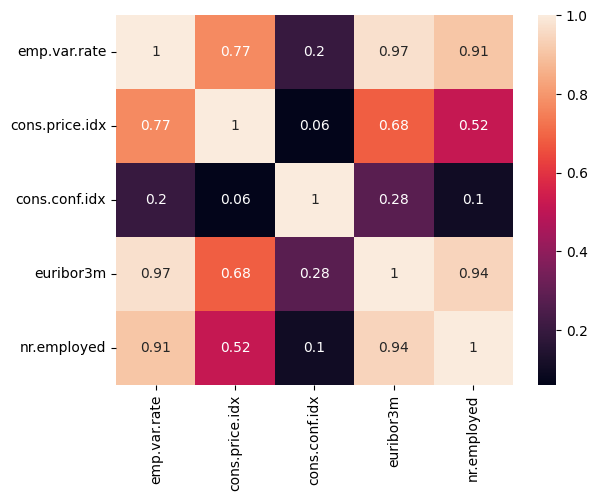

In [29]:
# check the correlation between socioeconomic features
soc_econ_features = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
m_corr = df[soc_econ_features].corr()
sns.heatmap(m_corr, annot=True)

We have highly correlated features. This might be a problem for some ML models. Possibly we will have to drop some of them depending on the chosen model.

[PIPELINE]
1. Possibly drop one or more soc_econ columns due to high correlation (test what columns are more important to model)

### 4. `loan` and `housing` features

Although these features are considered useless we will keep them for now and see if they really will not help model to predict

In [30]:
pd.crosstab(df['loan'].fillna('missing'), df['housing'].fillna('missing'), margins=True)

housing,no,unknown,yes,All
loan,,,,
no,11208,0,12493,23701
unknown,0,707,0,707
yes,1805,0,2618,4423
All,13013,707,15111,28831


These 707 'unknown' values are shared indeed. These features may correspond with age (housing loans might be paid off by elders) / job (due to bank's processes of credit scoring) / education / marital status

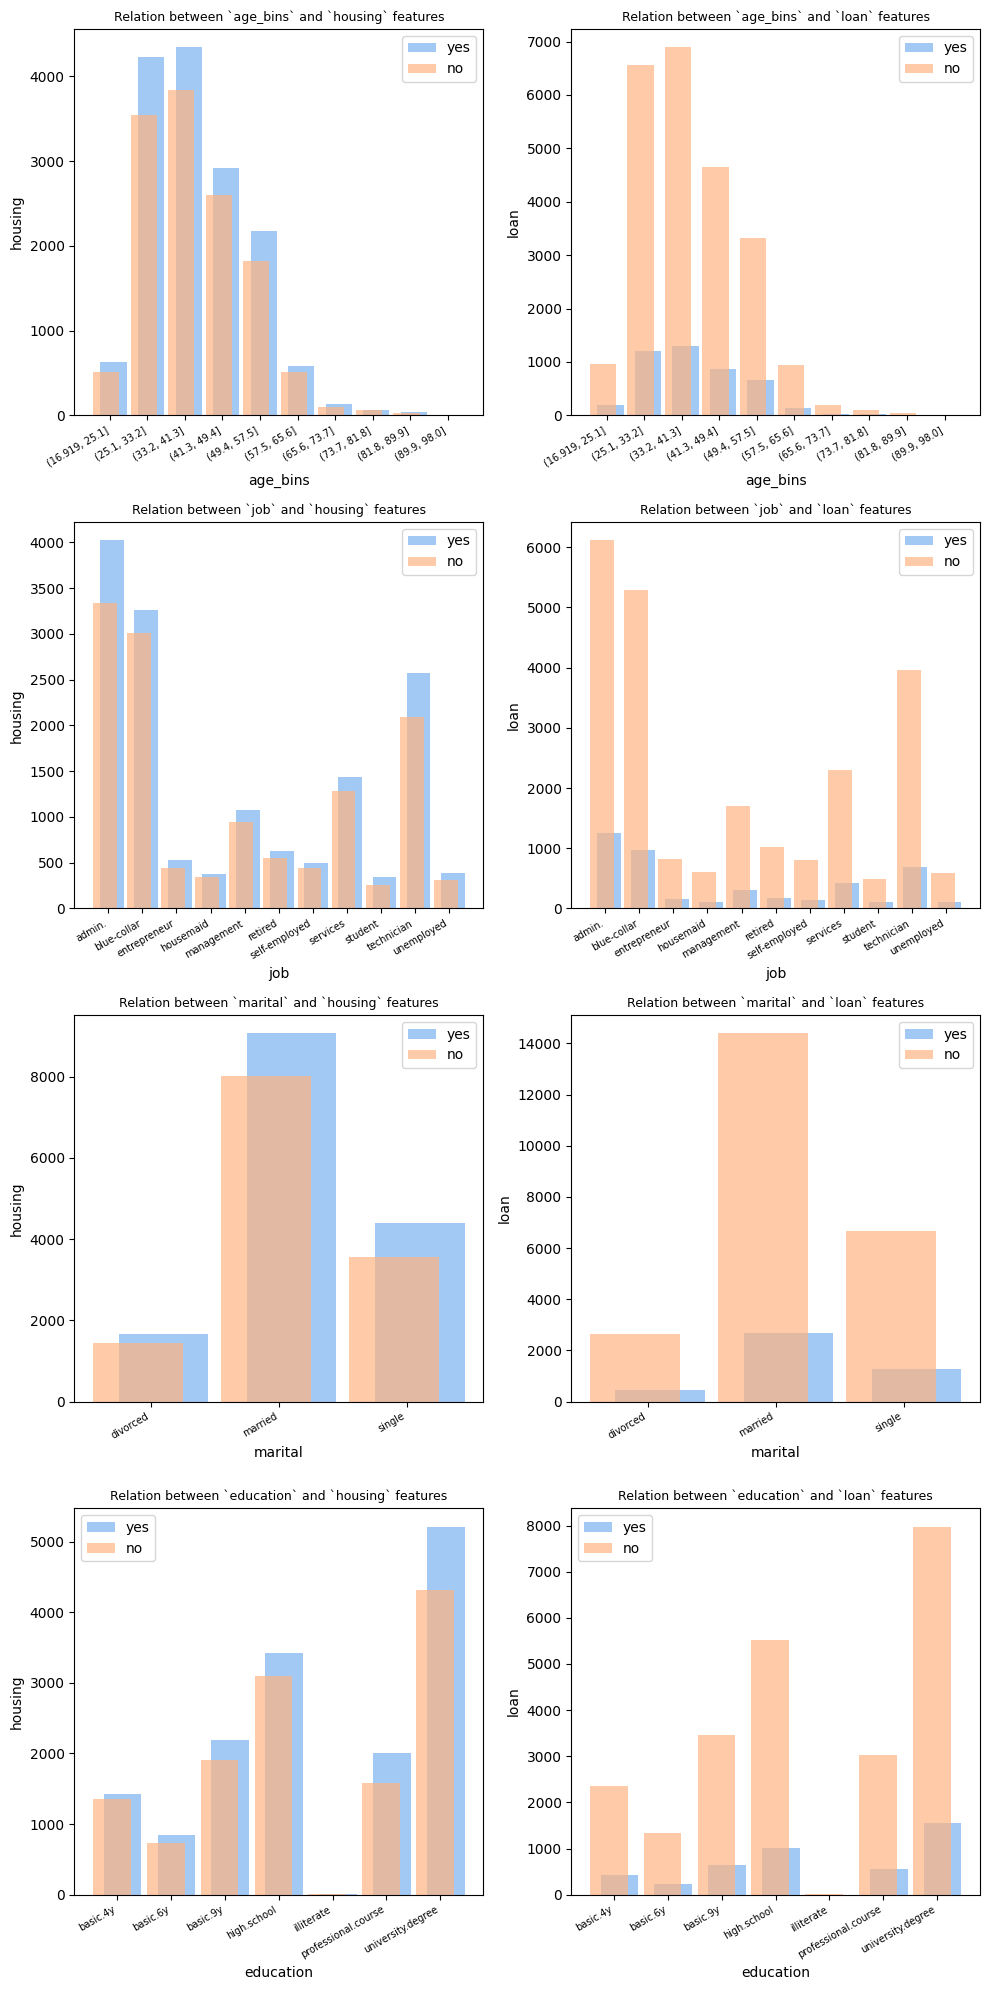

In [32]:
x_features = ['age_bins', 'age_bins', 'job', 'job', 'marital', 'marital', 'education', 'education']
y_features = ['housing', 'loan', 'housing', 'loan', 'housing', 'loan', 'housing', 'loan']

chart_rows, charts_per_row = 4, 2
sns.set_palette('pastel')
fig, axs = plt.subplots(chart_rows, charts_per_row, figsize=(5*charts_per_row,  5*chart_rows))

for ax, x_feature, y_feature in zip(axs.flatten(), x_features, y_features):
    ct = pd.crosstab(df[x_feature], df[y_feature])

    ax.bar(x=[x+0.1 for x in range(len(ct))], height=ct['yes'], width=0.7, label='yes')
    ax.bar(x=[x-0.1 for x in range(len(ct))], height=ct['no'], width=0.7, alpha=0.7, label='no')
    ax.set_xticks(range(len(ct)))
    ax.set_xticklabels([str(x) for x in ct.index], fontsize=7, rotation=30, ha='right')
    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)
    ax.legend()
    ax.set_title(f'Relation between `{x_feature}` and `{y_feature}` features', fontsize=9)
plt.tight_layout();

[PIPELINE]  
Option 1: Impute missing values using following default values: 'yes' for `housing` feature and 'no' for `loan` feature as these values are observed across all individual features  
Option 2: Replace values in feature by WoE values using 'unknown' values as separate group

In [33]:
# option 1
feat = 'housing'
m = (df[feat] == 'unknown') # boolean mask to filter rows
df.loc[m, feat]

56       unknown
96       unknown
137      unknown
138      unknown
227      unknown
          ...   
28701    unknown
28734    unknown
28750    unknown
28785    unknown
28788    unknown
Name: housing, Length: 707, dtype: object

In [34]:
df.loc[m, feat] = 'yes'
df.loc[m, feat]

56       yes
96       yes
137      yes
138      yes
227      yes
        ... 
28701    yes
28734    yes
28750    yes
28785    yes
28788    yes
Name: housing, Length: 707, dtype: object

Now we have all 'unknown' replaced with 'yes' in `housing`. Let's do the same for `loan` but with 'no' value

In [35]:
feat = 'loan'
m = (df[feat] == 'unknown') # boolean mask to filter rows
df.loc[m, feat] = 'no'
df.loc[m, feat]

56       no
96       no
137      no
138      no
227      no
         ..
28701    no
28734    no
28750    no
28785    no
28788    no
Name: loan, Length: 707, dtype: object

### 5. `contact` feature


`contact` feature can be one-hot encoded with 1 column (check if this feature contains useful info for model)

In [36]:
df['contact'].value_counts(dropna=False)

cellular     18302
telephone    10529
Name: contact, dtype: int64

In [37]:
# converting to binary integer 'Cellular or not' 
df['contact'] = df['contact'].map({'cellular': 1.0, 'telephone': 0.0})
df['contact'].value_counts()

1.0    18302
0.0    10529
Name: contact, dtype: int64

[PIPELINE]  
Option 1: Convert `contact` feature to one-hot encoded form by replacing 'cellular' with 1.0 and 'telephone' with 0.0  
Option 2: Replace values to WoE estimates

### 6. Assumption checked (see 1_...ipynb and comment in cell 7 above)

### 7. `day_of_week` feature

In [38]:
woe, iv = get_woe_cat(df['day_of_week'], df['y'])
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))
woe

Information Value: 0.0034 (useless)


feature
fri   -0.014867
mon   -0.104080
thu    0.065041
tue    0.014815
wed    0.033534
Name: woe, dtype: float64

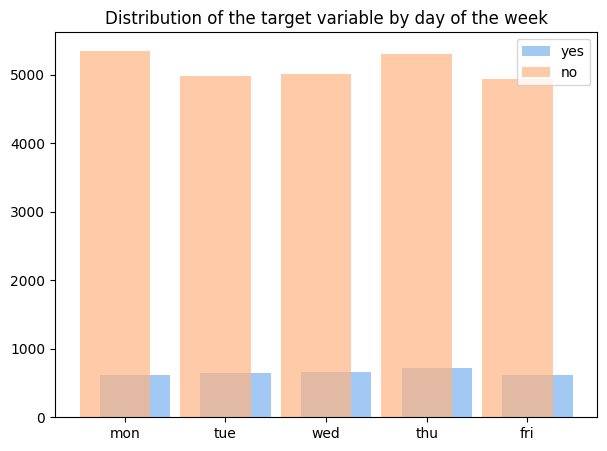

In [39]:
sorted_dow = ['mon', 'tue', 'wed', 'thu', 'fri']
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ct = pd.crosstab(df['day_of_week'], df['y'])
ax.bar(x=[x+0.1 for x in range(len(sorted_dow))], height=[ct.loc[x, target_positive] for x in sorted_dow], width=0.7, label='yes')
ax.bar(x=[x-0.1 for x in range(len(sorted_dow))], height=[ct.loc[x, target_negative] for x in sorted_dow], width=0.7, alpha=0.7, label='no')
ax.set_xticks(range(len(ct)))
ax.set_xticklabels(sorted_dow)
ax.set_title('Distribution of the target variable by day of the week')
ax.legend();

There are small variations between days but it will be better to test experimentally if this feature is useful for model  
  
[PIPELINE]  
Option 1: Map ['mon', 'tue', 'wed', 'thu', 'fri'] => [1, 2, 3, 4, 5]  
Option 2: Replace with WoE estimates

### 8. `campaign` feature

Reminder: `campaign` - number of contacts performed during this campaign and for this client (numeric, includes last contact)  
`campaign` feature skewed (long right tail) should be cutted based on 1.5*IQR

In [40]:
# check predictive power for initial feature based on WOE/IV
woe, iv = get_woe_cat(df['campaign'], df['y'])
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))

Information Value: 0.0485 (weak)


feature
1     0.145492
2     0.046585
3    -0.041643
4    -0.201180
5    -0.466088
6    -0.282854
7    -0.568323
8    -0.961655
9    -0.702145
10   -0.559470
11   -0.525961
12   -1.049658
13   -0.599016
14   -1.056486
15   -0.365635
16   -0.910418
17   -0.446216
18   -0.641346
19   -0.461421
20   -0.599308
21   -0.485763
22   -0.384624
23   -0.329940
24   -0.357656
25   -0.178516
26   -0.241863
27   -0.301434
28   -0.178516
29   -0.210691
30   -0.178516
31   -0.178516
32   -0.075272
33   -0.110884
34   -0.038344
35   -0.145272
37   -0.038344
40   -0.038344
42   -0.075272
43   -0.075272
56   -0.038344
Name: woe, dtype: float64

In [41]:
df['campaign'].describe()

count    28831.000000
mean         2.557490
std          2.753098
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign, dtype: float64

<AxesSubplot: >

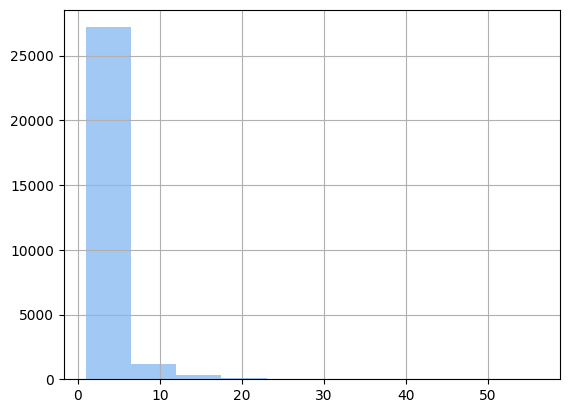

In [42]:
# check distribution by histogram
df['campaign'].hist()

<AxesSubplot: xlabel='campaign'>

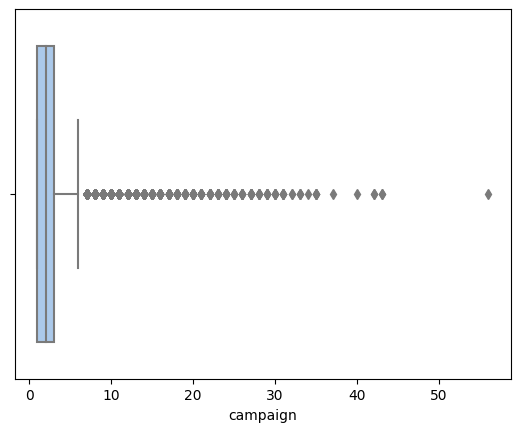

In [43]:
# check distribution by boxplot + identifying outliers
sns.boxplot(data=df, x='campaign')

In [44]:
# consider outliers as values > Q3 + 1.5*IQR
q1 = df['campaign'].quantile(0.25)
q3 = df['campaign'].quantile(0.75)
iqr = q3 - q1
cutoff_val = q3 + 1.5 * iqr
print(f'Q1  = {q1}')
print(f'Q3  = {q3}')
print(f'IQR = {iqr}')
print(f'Cutoff value: {cutoff_val}')
# df[df['campaign'] > cutoff_val]['campaign'] # to show outliers

Q1  = 1.0
Q3  = 3.0
IQR = 2.0
Cutoff value: 6.0


yes/no ratio for `campaign` values
1.0: 0.147
2.0: 0.133
3.0: 0.122
4.0: 0.103
5.0: 0.078
6.0: 0.060


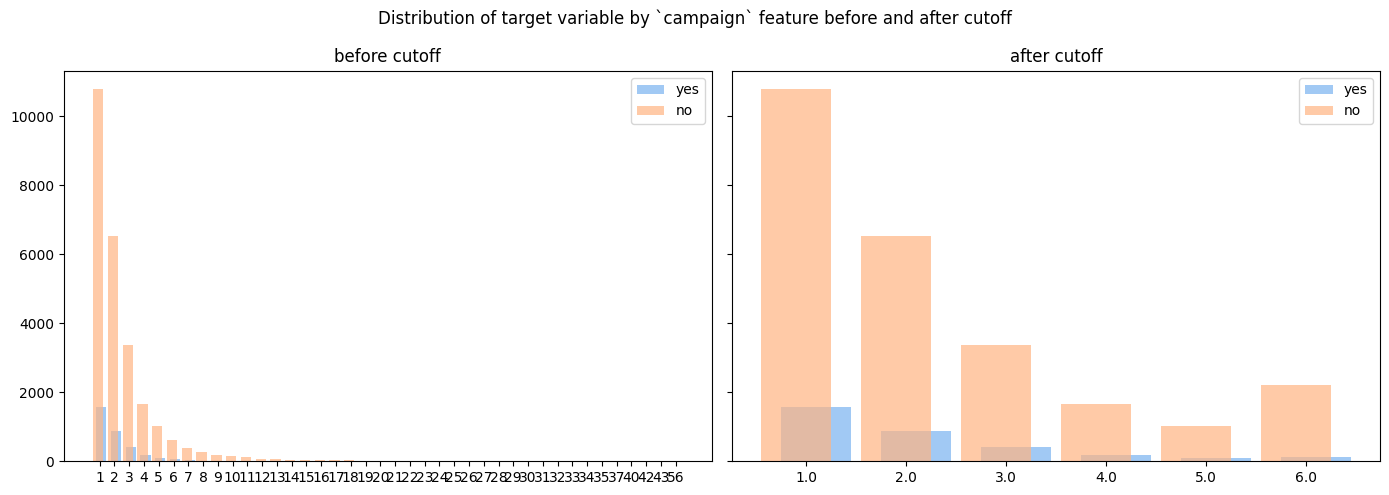

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(14,5), sharey=True)
ct = pd.crosstab(df['campaign'], df['y'])
ax[0].bar(x=[x+0.1 for x in range(len(ct.index))], height=ct[target_positive], width=0.7, label='yes')
ax[0].bar(x=[x-0.1 for x in range(len(ct.index))], height=ct[target_negative], width=0.7, alpha=0.7, label='no')
ax[0].set_xticks(range(len(ct)))
ax[0].set_xticklabels(ct.index)
ax[0].legend()
ax[0].set_title('before cutoff')

ct = pd.crosstab(df['campaign'].apply(lambda x: np.min([x, cutoff_val])), df['y'])
ax[1].bar(x=[x+0.1 for x in range(len(ct.index))], height=ct[target_positive], width=0.7, label='yes')
ax[1].bar(x=[x-0.1 for x in range(len(ct.index))], height=ct[target_negative], width=0.7, alpha=0.7, label='no')
ax[1].set_xticks(range(len(ct)))
ax[1].set_xticklabels(ct.index)
ax[1].legend()
ax[1].set_title('after cutoff')
fig.suptitle('Distribution of target variable by `campaign` feature before and after cutoff')
fig.tight_layout();
print('yes/no ratio for `campaign` values')
# yes / no values ratio for information
for x in ct.index:
    print('{}: {:.3f}'.format(x, ct.loc[x, 1]/ct.loc[x, 0]))

In [46]:
# performing real cutoff to dataset
df['campaign'] = df['campaign'].apply(lambda x: np.min([x, cutoff_val]))

In [47]:
# check predictive power for cutted feature based on WOE/IV
woe, iv = get_woe_cat(df['campaign'], df['y'])
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))
woe

Information Value: 0.0535 (weak)


feature
1.0    0.145492
2.0    0.046585
3.0   -0.041643
4.0   -0.201180
5.0   -0.466088
6.0   -0.737225
Name: woe, dtype: float64

<AxesSubplot: xlabel='feature', ylabel='woe'>

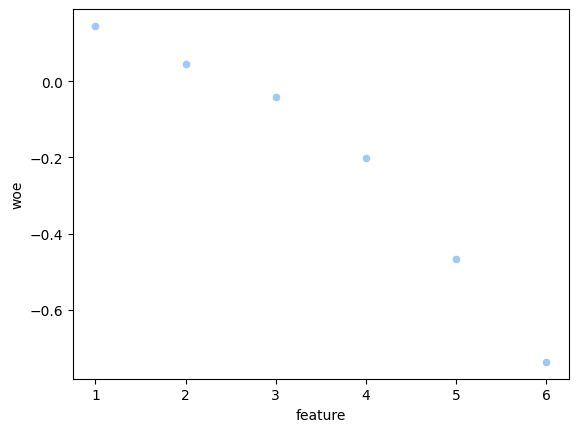

In [48]:
# check monotonity
sns.scatterplot(data=woe.reset_index(), x='feature', y='woe')

Here we see monotonic decreasing of WOE values which is necessary for prediction purpose. Predictive power of this `campaign` feature cutted-off to value 6 is weak but it still can be used for prediction  

[PIPELINE] In `campaign` feature replace outliers which a greater than 6 (Q3+1.5*IQR) with 6

### 9. Explore `pdays`, `previous`, `poutcome` features

Explore `pdays`, `previous`, `poutcome` features:
- `pdays` contains hidden NAN value (999) in 96% of records => can be dropped (+ explore correlation with `previous` and `poutcome` features)
- `previous` feature contains zeros in 86% of records => check if can be dropped (+ explore correlation with `pdays` and `poutcome` features)
- `poutcome` feature contains 'nonexistent' value in 86% of records (probably the same where `previous` == 0) 

Reminder:  
`pdays` - number of days that passed by after the client was last contacted from a previous campaign  
`previous` - number of contacts performed before this campaign and for this client (numeric)  
`poutcome` - outcome of the previous marketing campaign

#### 9.1. Exploring `pdays` feature

In [49]:
# check predictive power for initial feature based on WOE/IV
woe, iv = get_woe_cat(df['pdays'], df['y'])
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))
woe

Information Value: 0.4711 (strong)


feature
0      0.970527
1      0.495460
2      1.664608
3      2.563670
4      1.705942
5      1.557296
6      2.649777
7      1.827444
8      1.096879
9      1.412755
10     1.580023
11     1.177143
12     1.392460
13     1.726317
14     0.970059
15     1.431414
16     0.821047
17     0.269117
18     0.543338
19     0.230065
20    -0.038344
21     0.479808
22     0.441464
25     0.268409
26     0.268409
27     0.268409
999   -0.222954
Name: woe, dtype: float64

In [50]:
print('Absent-like values ratio: {:.2f}%'.format(df['pdays'].value_counts()[999] * 100 / len(df)))

Absent-like values ratio: 96.20%


In [51]:
pd.crosstab(df['y'], df['pdays'], margins=True)

pdays,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,25,26,27,999,All
y,,,,,,,,,,,,,,,,,,,,,
0,5,14,21,105,42,13,92,14,4,19,...,3,1,1,0,1,0,0,0,25177,25583
1,7,5,28,212,44,20,208,28,8,20,...,3,1,0,2,2,1,1,1,2557,3248
All,12,19,49,317,86,33,300,42,12,39,...,6,2,1,2,3,1,1,1,27734,28831


<AxesSubplot: xlabel='pdays'>

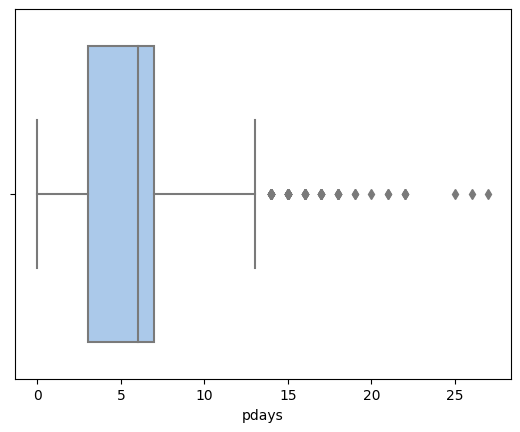

In [52]:
# boxplot of pdays to detect outlier values (excluding value 999)
sns.boxplot(data=df[df['pdays'] < 999], x='pdays')

In [53]:
# check what values are beyond Q3+1.5*IQR (except value 999)
q1 = df[df['pdays'] < 999]['pdays'].quantile(0.25)
q3 = df[df['pdays'] < 999]['pdays'].quantile(0.75)
iqr = q3 - q1
cutoff_val = q3 + 1.5 * iqr
print(f'Q1  = {q1}')
print(f'Q3  = {q3}')
print(f'IQR = {iqr}')
print(f'Cutoff value: {cutoff_val}')

Q1  = 3.0
Q3  = 7.0
IQR = 4.0
Cutoff value: 13.0


In [54]:
# check predictive power for cutted-off feature (excluded 999 value) based on WOE/IV
woe, iv = get_woe_cat(df[df['pdays'] < 999]['pdays'].apply(lambda x: np.min([13.0, x])), df['y'])
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))
woe

Information Value: 0.4421 (strong)


feature
0.0     0.970527
1.0     0.495460
2.0     1.664608
3.0     2.563670
4.0     1.705942
5.0     1.557296
6.0     2.649777
7.0     1.827444
8.0     1.096879
9.0     1.412755
10.0    1.580023
11.0    1.177143
12.0    1.392460
13.0    2.091001
Name: woe, dtype: float64

<AxesSubplot: xlabel='feature', ylabel='woe'>

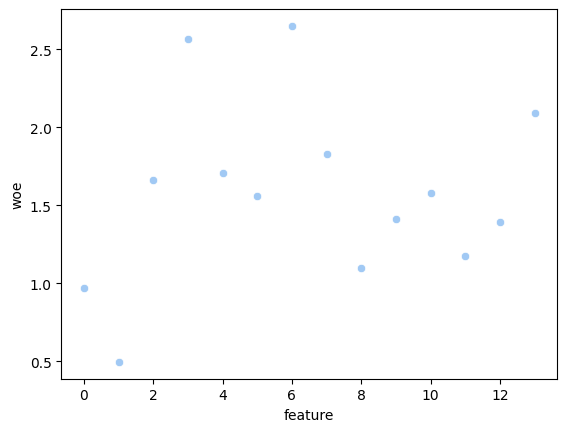

In [55]:
# check monotonity
sns.scatterplot(data=woe.reset_index(), x='feature', y='woe')

Further feature binning may be required

In [56]:
ct = pd.crosstab(df[df['pdays'] < 999]['pdays'], df['y']).sort_index(axis=0)
ct.transpose()

pdays,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,25,26,27
y,,,,,,,,,,,,,,,,,,,,,
0,5,14,21,105,42,13,92,14,4,19,...,3,6,3,1,1,0,1,0,0,0
1,7,5,28,212,44,20,208,28,8,20,...,5,2,3,1,0,2,2,1,1,1


Seems in most cases if client was contacted in previous campaign the probability of positive decision is higher. Let's check it visually

"\nprint('yes/no ratio for `pdays` values')\nfor x in ct.index:\n    print('{}: {:.3f}'.format(x, (ct.loc[x, 'yes']+1)/(ct.loc[x, 'no']+1)))\n"

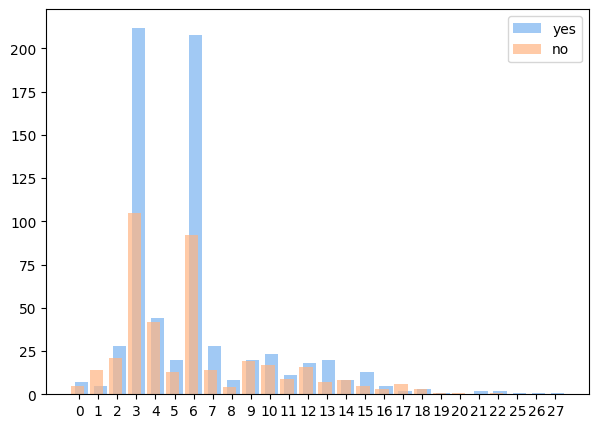

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.bar(x=[x+0.1 for x in range(len(ct.index))], height=ct[target_positive], width=0.7, label='yes')
ax.bar(x=[x-0.1 for x in range(len(ct.index))], height=ct[target_negative], width=0.7, alpha=0.7, label='no')
ax.set_xticks(range(len(ct)))
ax.set_xticklabels(ct.index)
ax.legend();
"""
print('yes/no ratio for `pdays` values')
for x in ct.index:
    print('{}: {:.3f}'.format(x, (ct.loc[x, 'yes']+1)/(ct.loc[x, 'no']+1)))
"""

We have 2 peaks here. Think in case of binning they should refer to different bins.  
[PIPELINE] Options to apply to `pdays` feature:  
1. Drop feature
2. Split values to bins considering values 3 and 6 as anchor points (base example: [0, 4), [4, 7), [7, 50), [50, 1000)) and apply WoE estimates  
3. Create additional feature `was_contacted`

Let's try to evaluate predictive power of binning from unit 2 above

In [58]:
# creating bins
pdays_bins = pd.IntervalIndex.from_breaks([-1, 3, 6, 13, 50, 999], closed='right')
pdays_bins

IntervalIndex([(-1, 3], (3, 6], (6, 13], (13, 50], (50, 999]], dtype='interval[int64, right]')

In [59]:
#creating new feature by applying bins
df['pdays_bin'] = pd.cut(df['pdays'], bins=pdays_bins)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education_ordered,age_bins,pdays_bin
0,50,blue-collar,single,basic.4y,0.150267,no,no,0.0,may,thu,...,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0,basic.4y,"(49.4, 57.5]","(50, 999]"
1,51,services,married,professional.course,-0.819063,no,no,0.0,may,mon,...,nonexistent,1.1,93.994,-36.4,4.858,5191.0,0,professional.course,"(49.4, 57.5]","(50, 999]"
2,46,technician,divorced,professional.course,0.150267,yes,no,1.0,may,mon,...,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,0,professional.course,"(41.3, 49.4]","(50, 999]"
3,46,admin.,single,university.degree,0.150267,yes,no,0.0,jun,mon,...,nonexistent,1.4,94.465,-41.8,4.961,5228.1,0,university.degree,"(41.3, 49.4]","(50, 999]"
4,25,services,single,high.school,0.150267,no,no,1.0,may,thu,...,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,1,high.school,"(16.919, 25.1]","(50, 999]"


In [60]:
# check predictive power for cutted-off feature based on WOE/IV
feature = 'pdays_bin'
woe, iv = get_woe_cat(df[feature], df['y'])
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))
woe

Information Value: 0.5189 (suspicious)


feature
(-1, 3]      2.466902
(3, 6]       2.530683
(6, 13]      2.226209
(13, 50]     1.826214
(50, 999]   -0.222954
Name: woe, dtype: float64

Received value of predictive power for this binning is suspiciously high. We'll have to check real predictive power when testing model

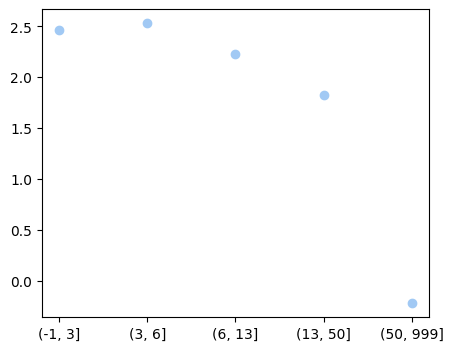

In [61]:
# check monotonity
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(x=range(len(woe)), y=woe.values)
ax.set_xticks(range(len(woe)))
ax.set_xticklabels([str(x) for x in woe.index]);

In [62]:
# encoding by WoE values
df['pdays'] = df['pdays_bin'].map(dict(zip(woe.index, woe.values)))
df = df.drop(columns='pdays_bin')
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education_ordered,age_bins
17886,38,admin.,single,high.school,0.150267,no,no,1.0,may,mon,...,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,0,high.school,"(33.2, 41.3]"
5318,39,self-employed,divorced,professional.course,0.150267,yes,no,0.0,jun,thu,...,0,nonexistent,1.4,94.465,-41.8,4.955,5228.1,0,professional.course,"(33.2, 41.3]"
28513,36,services,married,high.school,0.150267,yes,no,0.0,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,high.school,"(33.2, 41.3]"
28490,30,admin.,single,university.degree,-0.819063,yes,no,1.0,may,mon,...,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,0,university.degree,"(25.1, 33.2]"
25180,44,blue-collar,married,basic.6y,0.150267,no,no,1.0,apr,mon,...,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0,basic.6y,"(41.3, 49.4]"


#### 9.2. Exploring `previous` feature

In [63]:
print('Missing-like value `0` share: {:.2f}%'.format(df['previous'].value_counts()[0] *100 / len(df)))
df['previous'].value_counts()

Missing-like value `0` share: 86.15%


0    24838
1     3234
2      534
3      151
4       56
5       12
6        5
7        1
Name: previous, dtype: int64

`previous` feature seems like `pdays` as 86% of all values is 0  
Checking correspondence between `pdays` and `previous`  

[???] How can it be that `pdays` == 999 AND `previous` > 0 ?

In [64]:
# check predictive power for cutted-off feature based on WOE/IV
feature = 'previous'
woe, iv = get_woe_cat(df[feature], df['y'])
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))
woe

Information Value: 0.3323 (strong)


feature
0   -0.276437
1    0.755608
2    1.834273
3    2.115782
4    1.624691
5    1.096879
6    0.578950
7   -0.038344
Name: woe, dtype: float64

"\n# show positive / negative values ratio\nprint('yes/no ratio for `previous` values')\nfor x in ct.index:\n    print('{}: {:.3f}'.format(x, ct.loc[x, target_positive]/ct.loc[x, target_negative]))\n"

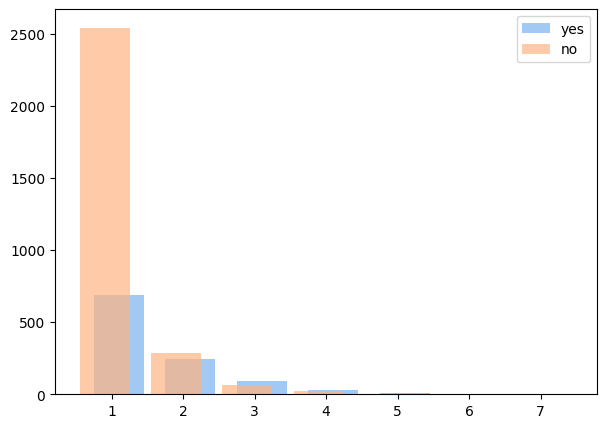

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ct = pd.crosstab(df[df['previous'] > 0]['previous'], df['y']).sort_index(axis=0)
ax.bar(x=[x+0.1 for x in range(len(ct.index))], height=ct[target_positive], width=0.7, label='yes')
ax.bar(x=[x-0.1 for x in range(len(ct.index))], height=ct[target_negative], width=0.7, alpha=0.7, label='no')
ax.set_xticks(range(len(ct)))
ax.set_xticklabels(ct.index)
ax.legend();
"""
# show positive / negative values ratio
print('yes/no ratio for `previous` values')
for x in ct.index:
    print('{}: {:.3f}'.format(x, ct.loc[x, target_positive]/ct.loc[x, target_negative]))
"""

<AxesSubplot: xlabel='previous'>

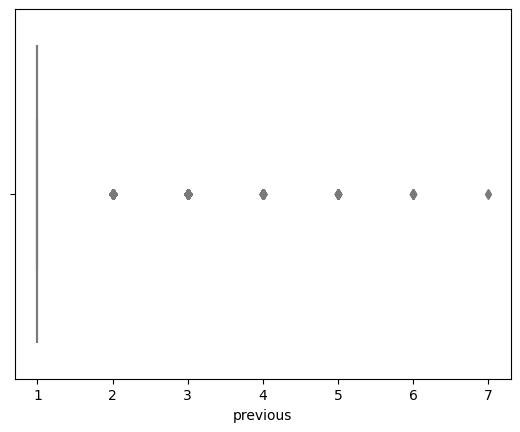

In [66]:
# boxplot of to detect outlier values (excluding value 0)
sns.boxplot(data=df[df['previous'] > 0], x='previous')

So each value except 1 can be treated as outlier.  
Let's find out if we can use WOE approach here ((1) each category contains >5% of sample size and (2) each category contains positive and negative target values)

In [67]:
print('Total num of records: {}, category threshold size: {}'.format(len(df), np.ceil(0.05 * len(df))))
print('With `0` value excluded - total: {} , threshold size: {}'.format(len(df[df['previous'] > 0]), np.ceil(0.05*len(df[df['previous'] > 0]))))
df.groupby(by='previous')[['previous', 'y']].agg({'previous': ['count'], 'y': ['sum', 'mean']})

Total num of records: 28831, category threshold size: 1442.0
With `0` value excluded - total: 3993 , threshold size: 200.0


previous     y          
            count   sum      mean
previous                         
0           24838  2181  0.087809
1            3234   691  0.213667
2             534   246  0.460674
3             151    89  0.589404
4              56    30  0.535714
5              12     8  0.666667
6               5     3  0.600000
7               1     0  0.000000

In [68]:
# assuming cutoff value 3 which will provide category threshold size > 200 after cutoff
# check predictive power for cutted-off feature based on WOE/IV
feature = 'previous'
print('Calculating prediction strength of features:')
print('Feature \tIV')
print('-'*20)
woe, iv = get_woe_cat(df[feature].apply(lambda x: np.min([x, 3])), df['y'], return_details=True)
print('{} \t{:.4f} ({})'.format(feature, iv, interpret_iv(iv)))
woe

Calculating prediction strength of features:
Feature 	IV
--------------------
previous 	0.3417 (strong)


,num_events,num_nonevents,num_cat_total,events_share,nonevents_share,woe,iv
feature,,,,,,,
0,2181,22657,24838,0.671490,0.885627,-0.276437,0.059195
1,691,2543,3234,0.212746,0.099402,0.755608,0.085644
2,246,288,534,0.075739,0.011257,1.834273,0.118277
3,130,95,225,0.040025,0.003713,2.163762,0.078569


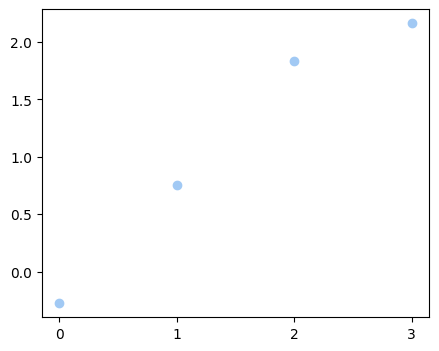

In [69]:
# check monotonity
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(x=range(len(woe)), y=woe['woe'])
ax.set_xticks(range(len(woe)))
ax.set_xticklabels([str(x) for x in woe.index]);

In [70]:
m = df['previous'] > 3
df.loc[m, 'previous']

72       5
605      4
686      4
1220     5
1376     4
        ..
26896    4
27035    5
27397    4
28124    4
28508    4
Name: previous, Length: 74, dtype: int64

In [71]:
# performing real cutoff
df['previous'] = df['previous'].apply(lambda x: np.min([x, 3]))
df.loc[m, 'previous']

72       3
605      3
686      3
1220     3
1376     3
        ..
26896    3
27035    3
27397    3
28124    3
28508    3
Name: previous, Length: 74, dtype: int32

[PIPELINE] We can test the same transformation type for `previous` feature as for `pdays`: leave out 0 value and encode groups '1', '2' and '>=3'

#### 9.3. Exploring `poutcome` feature

In [72]:
df['poutcome'].value_counts()

nonexistent    24838
failure         3003
success          990
Name: poutcome, dtype: int64

In [73]:
# check predictive power
feature = 'poutcome'
woe, iv = get_woe_cat(df[feature], df['y'])
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))
woe

Information Value: 0.5355 (suspicious)


feature
failure        0.280533
nonexistent   -0.276437
success        2.576719
Name: woe, dtype: float64

yes/no ratio for `poutcome` values
failure: 0.168
nonexistent: 0.096
success: 1.781


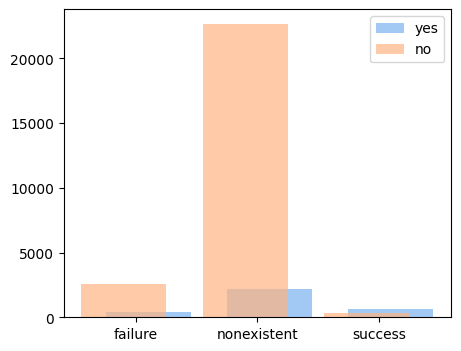

In [74]:
ct = pd.crosstab(df['poutcome'], df['y'])

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.bar(x=[x+0.1 for x in range(len(ct.index))], height=ct[target_positive], width=0.7, label='yes')
ax.bar(x=[x-0.1 for x in range(len(ct.index))], height=ct[target_negative], width=0.7, alpha=0.7, label='no')
ax.set_xticks(range(len(ct)))
ax.set_xticklabels(ct.index)
ax.legend();
print('yes/no ratio for `poutcome` values')
for x in ct.index:
    print('{}: {:.3f}'.format(x, ct.loc[x, target_positive]/ct.loc[x, target_negative]))

In [75]:
prev_campaign_ratio = pd.crosstab(df['poutcome'], df['previous'])
prev_campaign_ratio

previous,0,1,2,3
poutcome,,,,
failure,0,2610,310,83
nonexistent,24838,0,0,0
success,0,624,224,142


Comparing if previous campaign effectiveness is similar with last campaign depending on `previous` feature value

In [76]:
print('Campaigns effectiveness comparing (success/failure ratio):')
print('Num \tPrev \tLast')
for i in range(1, len(prev_campaign_ratio.columns)):
    prev_ratio = (prev_campaign_ratio.loc['success', i]) / (prev_campaign_ratio.loc['failure', i])
    last_ratio = len(df[(df['y'] == target_positive) & (df['previous'] == i)]) / len(df[(df['y'] == target_negative) & (df['previous'] == i)])
    print('{} \t{:.2f} \t{:.2f}'.format(i, prev_ratio, last_ratio))

Campaigns effectiveness comparing (success/failure ratio):
Num 	Prev 	Last
1 	0.24 	0.27
2 	0.72 	0.85
3 	1.71 	1.37


Success rate for the previous campaign is similar to last campaign => poutcome might be a good predictor for values  
[PIPELINE]  
Replace values by WoE estimates

[NOTE] THINK ABOUT ENCODING: test similar to WoE values to predict. 'nonexistent' value can be equivalent to success / failure ratio of the previous marketing campaign = 1 (50/50, unknown), <1 = more failure, >1 = more success  

### 10. Drop `duration` feature

In [77]:
df = df.drop(columns='duration')

## Final look of the dataset

In [78]:
# check if missing-like values remained
print(f'Calculating real NaNs ratio using `{cat_nan_equiv}` and `{num_nan_equiv}` keyvalues:')
print('Column (value) \tNvalues \tRatio')
print('-'*40)
for col in df.columns:
    if df[col].dtype == 'object':
        nan_equiv = cat_nan_equiv
    else:
        nan_equiv = num_nan_equiv
    if nan_equiv in list(df[col]):
        freq_table = df[col].value_counts()
        print('{} (`{}`) \t{} \t{:.1f}%'.format(col, nan_equiv, freq_table[nan_equiv], 100 * freq_table[nan_equiv] / len(df)))

Calculating real NaNs ratio using `unknown` and `999` keyvalues:
Column (value) 	Nvalues 	Ratio
----------------------------------------


In [79]:
df.sample(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education_ordered,age_bins
16272,35,blue-collar,married,basic.9y,-0.819063,yes,no,0.0,jun,fri,...,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0,basic.9y,"(33.2, 41.3]"
24221,37,technician,married,professional.course,0.150267,yes,no,0.0,may,wed,...,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,0,professional.course,"(33.2, 41.3]"
15656,31,admin.,married,university.degree,0.150267,yes,no,1.0,aug,thu,...,0,nonexistent,1.4,93.444,-36.1,4.962,5228.1,0,university.degree,"(25.1, 33.2]"
3676,35,admin.,married,university.degree,0.150267,yes,no,0.0,may,tue,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,university.degree,"(33.2, 41.3]"
16969,39,services,married,high.school,0.150267,no,no,0.0,jun,tue,...,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,0,high.school,"(33.2, 41.3]"
5156,32,admin.,single,university.degree,0.150267,yes,no,1.0,aug,tue,...,0,nonexistent,1.4,93.444,-36.1,4.968,5228.1,1,university.degree,"(25.1, 33.2]"
4506,21,admin.,single,basic.9y,0.150267,yes,yes,0.0,may,tue,...,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,0,basic.9y,"(16.919, 25.1]"
16990,39,blue-collar,married,basic.9y,0.150267,no,yes,0.0,may,tue,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,basic.9y,"(33.2, 41.3]"
6458,41,management,married,basic.6y,0.150267,no,no,1.0,apr,thu,...,0,nonexistent,-1.8,93.075,-47.1,1.365,5099.1,1,basic.6y,"(33.2, 41.3]"
28627,30,admin.,married,high.school,-0.819063,yes,no,1.0,aug,wed,...,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,0,high.school,"(25.1, 33.2]"


In [80]:
df.shape

(28831, 22)